# Library loading

In [1]:
%matplotlib inline

import pandas as pd # manipulate dataframes
import matplotlib
import matplotlib.pyplot as plt # plotting
import numpy as np
np.random.seed = 167 # fix random seed for reproducibility
import time, h5py, neuravi, torch

from sklearn.metrics import mean_squared_error

from tqdm import tqdm 

# First we check if CUDA is available
print("CUDA AVAILABLE? ",torch.cuda.is_available())

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
      
device = get_default_device()
print(device)

CUDA AVAILABLE?  True
cuda


# Loading data

In [2]:
# custom data loader, automatically sent to device
ds = neuravi.data_loader("./data/DataSet_0p20val.hdf5",
                         "./data/NKAS_Raman.hdf5",
                         "./data/NKAS_density.hdf5",
                         "./data/NKAS_optical.hdf5",
                         "./data/NKAS_liquidus.hdf5",
                         device)

# Training 1 model 

Architecture: 4 layers, 300 neurons per layer, dropout 0.1

With such high dropout, we may want to increase the patience quite significantly.

In [45]:
nb_layers = 7
nb_neurons = 200
p_drop = 0.1

name = "./model/best/l"+str(nb_layers)+"_n"+str(nb_neurons)+"_p"+str(p_drop)+"_test"+".pth"

# declaring model
neuralmodel = neuravi.model(4,nb_neurons,nb_layers,ds.nb_channels_raman,p_drop=p_drop) 

# criterion for match
criterion = torch.nn.MSELoss()
criterion.to(device) # sending criterion on device
optimizer = torch.optim.Adam(neuralmodel.parameters(), lr = 0.001) # optimizer

# we initialize the output bias and send the neural net on device
neuralmodel.output_bias_init()
neuralmodel = neuralmodel.float()
neuralmodel.to(device)


model(
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (linears): ModuleList(
    (0): Linear(in_features=4, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): Linear(in_features=200, out_features=200, bias=True)
  )
  (out_thermo): Linear(in_features=200, out_features=18, bias=True)
  (out_raman): Linear(in_features=200, out_features=850, bias=True)
)

In [46]:
#
# PRETRAINING
#
neuralmodel, record_pretrain_loss, record_prevalid_loss = neuravi.training(neuralmodel,ds,criterion,optimizer,name, mode="pretrain",verbose=False)

#
# TRAINING
#
neuralmodel, record_train_loss, record_valid_loss = neuravi.training(neuralmodel,ds,
                                                                     criterion,optimizer,name,
                                                                     train_patience=200,min_delta=0.05,
                                                                     verbose=True)

Full training.

Epoch 0 => train loss: 11.743310928344727; valid loss: 15.087806701660156
Epoch 200 => train loss: 3.4802262783050537; valid loss: 8.282824516296387
Epoch 400 => train loss: 2.8273916244506836; valid loss: 7.809104919433594
Epoch 600 => train loss: 2.3291432857513428; valid loss: 7.59657096862793
Running time in seconds: 69.2743878364563
Scaled valid loss values are 1.49, 0.12, 0.53, 2.04, 0.16, 3.12, 0.58 for Tg, Raman, density, entropy, ri, Tl and viscosity (AG)


# Observing how losses decline

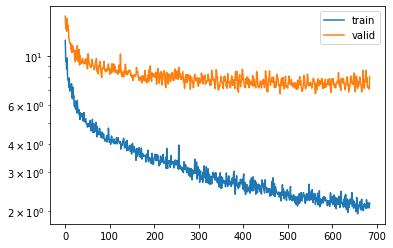

In [47]:
plt.plot(record_train_loss,label="train")
plt.plot(record_valid_loss,label="valid")
plt.legend()
plt.yscale("log")

In [48]:
y_pred_visco = neuralmodel.ag(ds.x_visco_test,ds.T_visco_test)


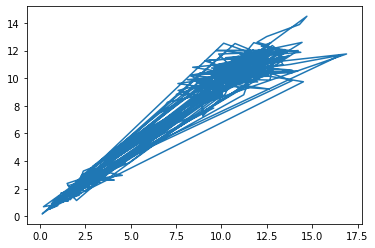

In [49]:
plt.plot(y_pred_visco.cpu().detach().numpy(),ds.y_visco_test.cpu().detach().numpy())

In [50]:
np.sum(np.sqrt((y_pred_visco.cpu().detach().numpy()-ds.y_visco_test.cpu().detach().numpy())**2))/len(y_pred_visco)

0.6185426675496887

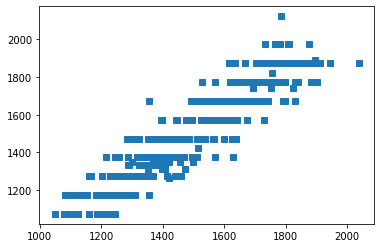

In [51]:
plt.plot(neuralmodel.tl(ds.x_tl_test).cpu().detach().numpy(),ds.y_tl_test.cpu().detach().numpy(),"s")

In [52]:
criterion(y_pred_visco,ds.y_visco_test)

tensor(0.9159, device='cuda:0', grad_fn=<MseLossBackward>)

In [53]:
criterion(neuralmodel.tl(ds.x_tl_test),ds.y_tl_test)

tensor(9402.5625, device='cuda:0', grad_fn=<MseLossBackward>)

In [54]:
print("Loss values are {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}".format(1.,1.,1.,1.,1.))

Loss values are 1.00, 1.00, 1.00, 1.00, 1.00


In [55]:
np.sqrt(9288)

96.37427042525407